In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
import lightgbm as lgb
import eda_util
import matplotlib.pyplot as plt

c:\Users\User\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
random_state = 1048576

target = 'loan_status'

# Data Loading

In [10]:
test_csv = pd.read_csv('test.csv', index_col=0)
train_csv = pd.read_csv('train.csv', index_col=0)
original_csv = pd.read_csv('credit_risk_dataset.csv')

In [4]:
train_csv.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [6]:
test_csv.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [7]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [11]:
original_csv.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [12]:
original_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


# Train-Test Split

In [15]:
combined_csv = pd.concat([train_csv, original_csv])
print(f'Shape of combined: {combined_csv.shape}')


Shape of combined: (91226, 12)


In [16]:
X, y = eda_util.feature_target.feature_target_split(combined_csv, target=target)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=random_state)

# X_val, X_test, y_val, y_test = train_test_split(
#     X_test, y_test, test_size=0.5, random_state=random_state)
print(f'Shape of X_train is: {X_train.shape}; shape of y_train is: {y_train.shape}')
print(f'Shape of X_test is: {X_test.shape}; shape of y_test is: {y_test.shape}')

Shape of X_train is: (82103, 11); shape of y_train is: (82103,)
Shape of X_test is: (9123, 11); shape of y_test is: (9123,)


# Dealing with outliers

## Loan percentage

In [17]:
loan_income = X_train[['person_income' ,'loan_percent_income', 'loan_amnt']].copy()
loan_income['cal_loan_amnt'] = loan_income['person_income'] * loan_income['loan_percent_income']
loan_income['diff'] = loan_income['cal_loan_amnt'] - loan_income['loan_amnt']
loan_income['percent_diff'] = round(loan_income['diff'] / loan_income['cal_loan_amnt'] * 100, 2)
loan_income[abs(loan_income['percent_diff']) > 50].head(10)

,person_income,loan_percent_income,loan_amnt,cal_loan_amnt,diff,percent_diff
26534,98004,0.39,3600,38221.56,34621.56,90.58
17387,1900000,0.00,1500,0.00,-1500.00,-inf
1553,48000,0.02,10000,960.00,-9040.00,-941.67
42939,700000,0.03,2000,21000.00,19000.00,90.48
34752,928000,0.01,2850,9280.00,6430.00,69.29
46986,828000,0.06,4800,49680.00,44880.00,90.34
50761,115000,0.27,3250,31050.00,27800.00,89.53
25714,703800,0.01,12000,7038.00,-4962.00,-70.50
13744,40000,0.09,35000,3600.00,-31400.00,-872.22
36720,9600,0.08,7500,768.00,-6732.00,-876.56


In [18]:
wrong_loan_percent_ind = loan_income[abs(loan_income['percent_diff']) > 50].index
wrong_loan_percent_ind

Index([26534, 17387,  1553, 42939, 34752, 46986, 50761, 25714, 13744, 36720,
       ...
       34007, 38928, 41278, 38110, 15838, 20222, 49179, 44525, 56858, 37534],
      dtype='int64', length=113)

## Age related

In [19]:
work_time = X_train[['person_age', 'person_emp_length', 'cb_person_cred_hist_length']].copy()
work_time['start_working_age'] = work_time['person_age'] - work_time['person_emp_length']
work_time['start_cred'] = work_time['person_age'] - work_time['cb_person_cred_hist_length']
work_time[work_time['start_working_age'] < 14] # US legal working age starts at 14

,person_age,person_emp_length,cb_person_cred_hist_length,start_working_age,start_cred
56176,37,28.0,11,9.0,26
17542,38,27.0,13,11.0,25
26125,43,41.0,14,2.0,29
699,30,19.0,8,11.0,22
24214,43,35.0,16,8.0,27
20615,21,8.0,3,13.0,18
17861,33,21.0,7,12.0,26
3072,24,12.0,2,12.0,22
41079,28,123.0,6,-95.0,22
48185,23,10.0,3,13.0,20


In [20]:
wrong_age_ind = work_time[work_time['start_working_age'] < 14].index
wrong_age_ind

Index([56176, 17542, 26125,   699, 24214, 20615, 17861,  3072, 41079, 48185,
       48915, 32236, 16378, 12638, 48118, 41912, 15921, 34852, 49252,   746,
       18783, 33012, 18293, 52038, 53992,  8222,   210,     0],
      dtype='int64')

## Dropping the wrong data

In [21]:
drop_ind = np.concatenate([wrong_loan_percent_ind, wrong_age_ind])
drop_ind

array([26534, 17387,  1553, 42939, 34752, 46986, 50761, 25714, 13744,
       36720, 29451,  5054, 40429, 58340, 53056,  4455, 46574, 18917,
       19410, 31922, 32724, 45474,  9488, 37605, 22647, 31916, 18364,
       27877, 33165, 36496, 32297, 16134, 15679, 30528, 17783, 25959,
       37591, 25390, 53133, 55372, 19450, 50649, 15326, 14081,  1296,
       37345,   729, 52674, 12404, 26484, 49051, 19060,  4230, 54855,
       26911, 42205, 34384, 37171, 38249, 31093, 53756, 40121,  4557,
       52940, 39716, 17223, 51826, 37541, 51496, 52470, 37879, 23564,
       20901, 14314, 54527, 22203, 31924, 38167, 46500, 54980, 20632,
       54696, 20120, 20271, 50049, 11432, 30049, 13872, 48803, 35808,
       32512, 48199, 18718,  7965, 11422, 24325, 50430, 38295, 30309,
       43557, 35473, 11999, 10542, 34007, 38928, 41278, 38110, 15838,
       20222, 49179, 44525, 56858, 37534, 56176, 17542, 26125,   699,
       24214, 20615, 17861,  3072, 41079, 48185, 48915, 32236, 16378,
       12638, 48118,

In [22]:
X_train_dropped, y_train_dropped = X_train.drop(drop_ind), y_train.drop(drop_ind)
print(f'X_train shape: {X_train_dropped.shape}')
print(f'y_train shape: {y_train_dropped.shape}')

X_train shape: (81892, 11)
y_train shape: (81892,)


# Categorical Encoder

In [23]:
cat_features = [
    'person_home_ownership', 
    'loan_intent', 
    'loan_grade', 
    'cb_person_default_on_file'
]

num_features = [
    'person_age', 
    'person_income', 
    'person_emp_length', 
    'loan_amnt', 
    'loan_int_rate', 
    'loan_percent_income', 
    'cb_person_cred_hist_length'
]

In [24]:
cat_encoder = ColumnTransformer(
    [
        ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), cat_features)
    ], 
    remainder='passthrough'
)
cat_encoder.set_output(transform='pandas')
cat_encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_encoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=nan),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file'])])

In [25]:
X_train_encoded = cat_encoder.fit_transform(X_train_dropped).rename(columns=lambda x:x.split('__', 1)[-1]) # Discard the 'cat_encoder__' and 'passthrough__' prefices
X_train_encoded.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
42145,3.0,1.0,0.0,0.0,26,81600,8.0,4000,5.79,0.05,2
4808,3.0,0.0,1.0,0.0,22,24000,0.0,2450,9.76,0.10,4
28732,0.0,3.0,0.0,0.0,23,90000,5.0,5000,6.76,0.06,2
29779,3.0,1.0,1.0,0.0,26,140000,0.0,5000,9.99,0.04,2
31063,0.0,3.0,1.0,0.0,36,58650,0.0,10000,NaN,0.14,15


# Model Building

## Base Model

In [26]:
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_encoded, y_train_dropped, test_size=0.1, random_state=random_state)
print(f'X_train_base shape: {X_train_base.shape}')
print(f'y_train_base shape: {y_train_base.shape}')
print(f'X_val_base shape: {X_val_base.shape}')
print(f'y_val_base shape: {y_val_base.shape}')

X_train_base shape: (73702, 11)
y_train_base shape: (73702,)
X_val_base shape: (8190, 11)
y_val_base shape: (8190,)


In [30]:
base_model = lgb.LGBMClassifier(random_state=random_state)
base_model.fit(X_train_base, y_train_base, categorical_feature=cat_features, eval_set=(X_val_base, y_val_base), eval_metric='auc')
print(f'Training Score: {roc_auc_score(y_train_dropped, base_model.predict_proba(X_train_encoded)[:, 1])}')
print(f'Test Score: {roc_auc_score(y_test, base_model.predict_proba(cat_encoder.transform(X_test))[:, 1])}')

[LightGBM] [Info] Number of positive: 12404, number of negative: 61298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 73702, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168299 -> initscore=-1.597728
[LightGBM] [Info] Start training from score -1.597728
Training Score: 0.9667612411064742
Test Score: 0.9618210349595809


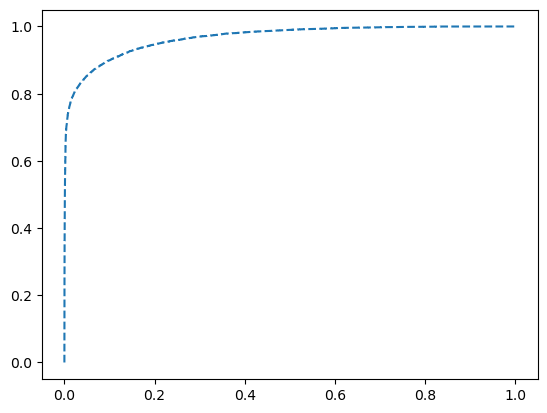

In [31]:
fpr, tpr, thresholds = roc_curve(y_train_dropped, base_model.predict_proba(X_train_encoded)[:,1])
plt.plot(fpr, tpr, linestyle='--')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

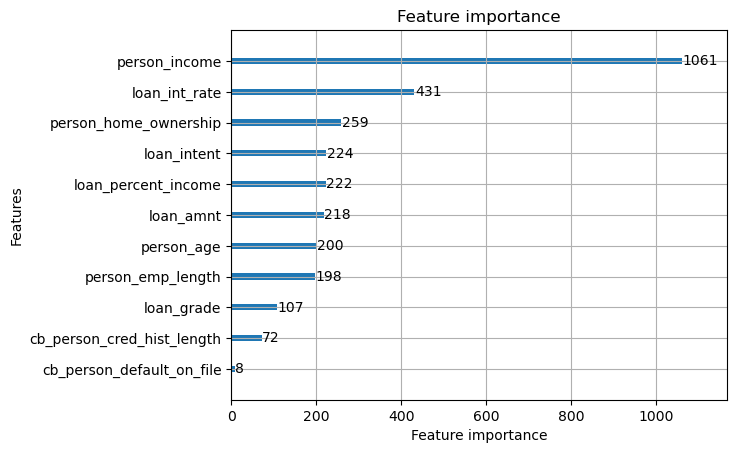

In [32]:
lgb.plot_importance(base_model)

## Bayes Search with 10-fold CV

In [38]:
kf = KFold(n_splits = 10, shuffle = True, random_state = random_state)        # Construct a 10-fold shuffler
clf = lgb.LGBMClassifier(random_state=1048576)                                # Base estimator
opt = BayesSearchCV(clf,                                                      # Param Space
                    {
                        "max_depth": Integer(3, 13),
                        "num_leaves": Integer(20, 200),
                        "min_child_samples": Integer(7, 75),
                        "colsample_bytree": Real(0.25, 1),
                        "subsample": Real(0.25, 1),
                        "subsample_freq": Integer(1, 50),
                        "reg_alpha": Real(0, 1),
                        "reg_lambda": Real(0, 1),
                        "min_split_gain": Real(0, 0.5)
                    },
                    n_iter = 150,
                    cv = kf,
                    n_jobs = 3,
                    random_state = random_state,
                    fit_params={"categorical_feature": cat_features, 
                        "eval_metric": 'auc'},         # Passing categorical features to LGBMClassifier
                   )
opt

BayesSearchCV(cv=KFold(n_splits=10, random_state=1048576, shuffle=True),
              estimator=LGBMClassifier(random_state=1048576),
              fit_params={'categorical_feature': ['person_home_ownership',
                                                  'loan_intent', 'loan_grade',
                                                  'cb_person_default_on_file'],
                          'eval_metric': 'auc'},
              n_iter=150, n_jobs=3, random_state=1048576,
              search_spaces={'colsample_bytree': Real(low=0.25, high=1, p...
                             'num_leaves': Integer(low=20, high=200, prior='uniform', transform='identity'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'subsample': Real(low=0.25, high=1, prior='uniform', transform='identity'),
                             'subsample_freq': Integer(low=1, high=50, prior='uniform', transform='identity')})

In [39]:
opt.fit(X_train_encoded, y_train_dropped)

display(opt.best_estimator_)

print(f'Best parameters are {opt.best_params_}')
print(f'Best score is {opt.best_score_}')

[LightGBM] [Info] Number of positive: 13866, number of negative: 68026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 81892, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169321 -> initscore=-1.590450
[LightGBM] [Info] Start training from score -1.590450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.6086877304063157, max_depth=12,
               min_child_samples=7, min_split_gain=0.5, num_leaves=138,
               random_state=1048576, reg_lambda=1.0, subsample_freq=50)

Best parameters are OrderedDict([('colsample_bytree', 0.6086877304063157), ('max_depth', 12), ('min_child_samples', 7), ('min_split_gain', 0.5), ('num_leaves', 138), ('reg_alpha', 0.0), ('reg_lambda', 1.0), ('subsample', 1.0), ('subsample_freq', 50)])
Best score is 0.9472353469789054


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

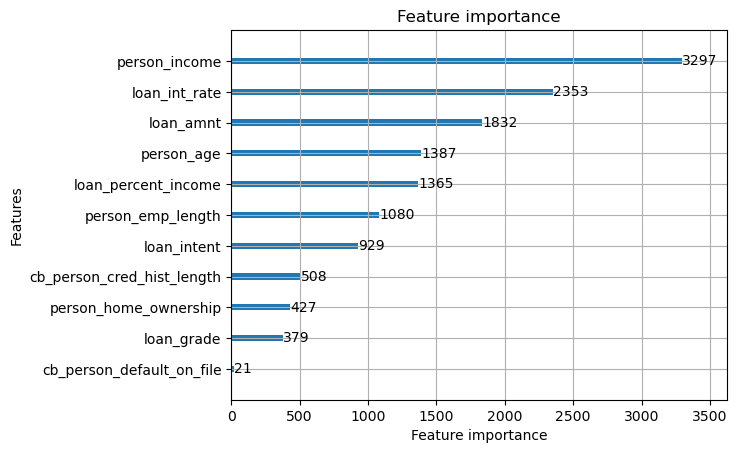

In [40]:
lgb.plot_importance(opt.best_estimator_)

In [41]:
best_lgb = opt.best_estimator_

In [42]:
print(f'Test AUC = {roc_auc_score(best_lgb.predict(cat_encoder.transform(X_test)), y_test)}')

Test AUC = 0.9457203637129313


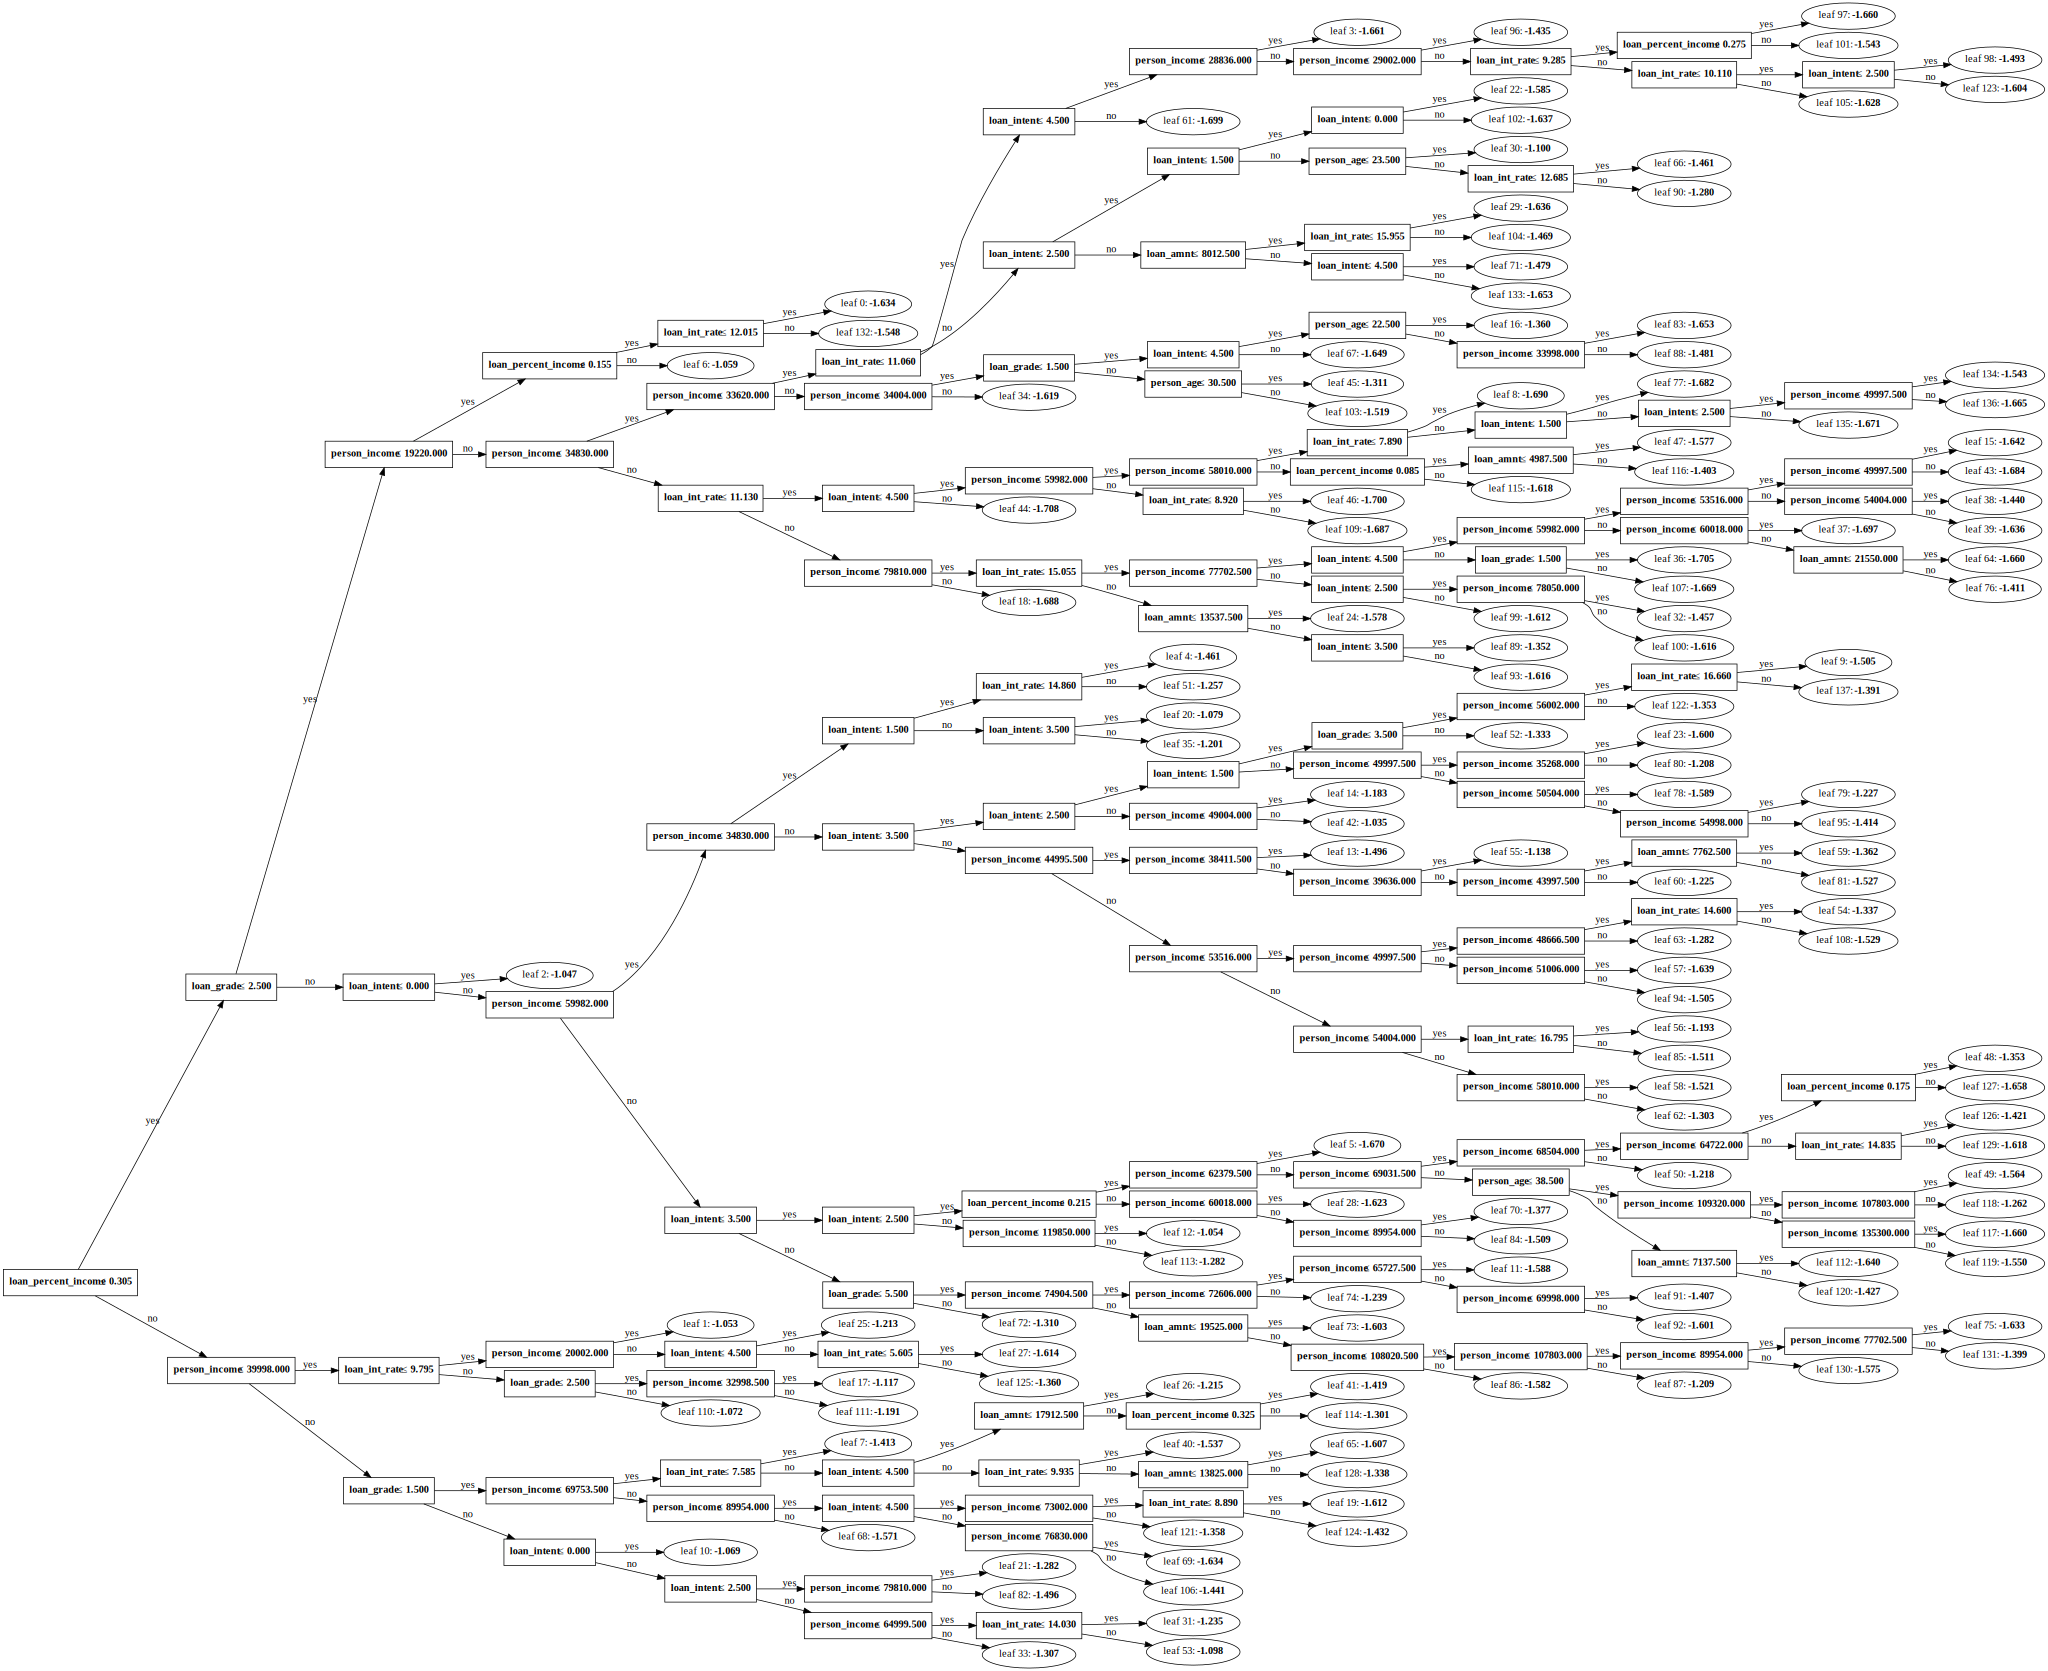

In [43]:
lgb.create_tree_digraph(best_lgb)

# Submit Prediction

## Base Model

In [33]:
cat_encoder.transform(test_csv)

,cat_encoder__person_home_ownership,cat_encoder__loan_intent,cat_encoder__loan_grade,cat_encoder__cb_person_default_on_file,remainder__person_age,remainder__person_income,remainder__person_emp_length,remainder__loan_amnt,remainder__loan_int_rate,remainder__loan_percent_income,remainder__cb_person_cred_hist_length
id,,,,,,,,,,,
58645,3.0,2.0,5.0,0.0,23,69000,3.0,25000,15.76,0.36,2
58646,0.0,4.0,2.0,1.0,26,96000,6.0,10000,12.68,0.10,4
58647,3.0,5.0,4.0,1.0,26,30000,5.0,4000,17.19,0.13,2
58648,3.0,0.0,0.0,0.0,33,50000,4.0,7000,8.90,0.14,7
58649,0.0,2.0,3.0,1.0,26,102000,8.0,15000,16.32,0.15,4
...,...,...,...,...,...,...,...,...,...,...,...
97738,0.0,0.0,1.0,0.0,22,31200,2.0,3000,10.37,0.10,4
97739,0.0,1.0,0.0,0.0,22,48000,6.0,7000,6.03,0.15,3
97740,0.0,4.0,0.0,0.0,51,60000,0.0,15000,7.51,0.25,25


In [36]:
y_pred = base_model.predict_proba(cat_encoder.transform(test_csv))[:, 1]

In [37]:
submission = pd.read_csv('sample_submission.csv', index_col=0)
print(submission.head())
submission[target] = y_pred
print('\n')
print(submission.head())
submission.to_csv('submission_LGBM_base_with_ori.csv')
print('Result saved successfully!')

       loan_status
id                
58645          0.5
58646          0.5
58647          0.5
58648          0.5
58649          0.5


       loan_status
id                
58645     0.985196
58646     0.028698
58647     0.431754
58648     0.016141
58649     0.102978
Result saved successfully!


In [47]:
y_pred = best_lgb.predict_proba(cat_encoder.transform(test_csv))[:, 1]

In [48]:
submission = pd.read_csv('sample_submission.csv', index_col=0)
print(submission.head())
submission[target] = y_pred
print('\n')
print(submission.head())
submission.to_csv('submission_LGBM_Bayes_with_ori.csv')
print('Result saved successfully!')

       loan_status
id                
58645          0.5
58646          0.5
58647          0.5
58648          0.5
58649          0.5


       loan_status
id                
58645     0.991767
58646     0.020822
58647     0.557935
58648     0.005936
58649     0.061795
Result saved successfully!
